## Weight decay
See chapter 3.7 for a detailed explanation on $l_p$-norms for regularization methods


In [1]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

We can illustrate the benefits of weight decay 
through a simple synthetic example.

$$y = 0.05 + \sum_{i = 1}^d 0.01 x_i + \epsilon \text{ where }
\epsilon \sim \mathcal{N}(0, 0.01^2).$$

In this synthetic dataset, our label is given 
by an underlying linear function of our inputs,
corrupted by Gaussian noise 
with zero mean and standard deviation 0.01.
For illustrative purposes, 
we can make the effects of overfitting pronounced,
by increasing the dimensionality of our problem to $d = 200$
and working with a small training set with only 50 examples.

In [2]:
# Set random seed for reproducibility
np.random.seed(42)

# Define parameters
d = 200  # Dimensionality
n_train = 50  # Number of training examples

# Generate random inputs
X_train = np.random.randn(n_train, d)

# Generate true coefficients
true_coefficients = np.ones(d) * 0.01

# Generate Gaussian noise
epsilon = np.random.normal(loc=0, scale=0.01, size=n_train)

# Generate labels
y_train = 0.05 + np.dot(X_train, true_coefficients) + epsilon

# Create a Pandas DataFrame
data = pd.DataFrame(data=X_train, columns=[f'x_{i}' for i in range(d)])
data['y'] = y_train

In [3]:
class CustomDataLoader:
    def __init__(self, data, target, val_size=0.2, test_size=0.2, batch_size=5):  
        self.batch_size = batch_size
        self.X_train, self.X_val, self.y_train, self.y_val = train_test_split(data.values, target.values, test_size=val_size, random_state=42)
        self.X_val, self.X_test, self.y_val, self.y_test = train_test_split(self.X_val, self.y_val, test_size=test_size, random_state=42)

        # If scaling is needed here the data is scaled


    def get_data_loaders(self):
        train_dataset = TensorDataset(torch.tensor(self.X_train, dtype=torch.float32),
            torch.tensor(self.y_train, dtype=torch.float32))
        val_dataset = TensorDataset(torch.tensor(self.X_val, dtype=torch.float32),
            torch.tensor(self.y_val, dtype=torch.float32))
        test_dataset = TensorDataset(torch.tensor(self.X_test, dtype=torch.float32),
            torch.tensor(self.y_test, dtype=torch.float32))
        
        
        train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=self.batch_size, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=self.batch_size, shuffle=False)

        return train_loader, val_loader, test_loader



X = data.drop(columns="y")
y = data["y"]
custom_loader = CustomDataLoader(X, y)
train_loader, val_loader, test_loader = custom_loader.get_data_loaders()

#### Normal regression

In [4]:
class Model(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.linear = nn.Linear(in_features, out_features) # If input size is unknown use LazyLinear
        
    def forward(self, x):
        y_pred = self.linear(x)
        return y_pred

model = Model(in_features=X.shape[1], out_features=1)
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.001)

Epoch 1/100, Train Loss: 0.1943, Test Loss: 0.1855
Epoch 11/100, Train Loss: 0.0331, Test Loss: 0.1412
Epoch 21/100, Train Loss: 0.0103, Test Loss: 0.1323
Epoch 31/100, Train Loss: 0.0040, Test Loss: 0.1294
Epoch 41/100, Train Loss: 0.0018, Test Loss: 0.1277
Epoch 51/100, Train Loss: 0.0008, Test Loss: 0.1264
Epoch 61/100, Train Loss: 0.0004, Test Loss: 0.1254
Epoch 71/100, Train Loss: 0.0002, Test Loss: 0.1246
Epoch 81/100, Train Loss: 0.0001, Test Loss: 0.1240
Epoch 91/100, Train Loss: 0.0001, Test Loss: 0.1235


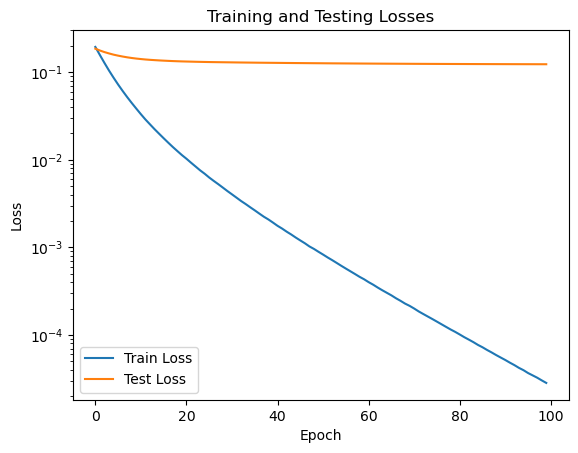

In [5]:
class Trainer:
    def __init__(self, model, optimizer, criterion, train_loader, val_loader):
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
        self.train_loader = train_loader
        self.val_loader = val_loader
    
    def train(self, max_epochs):
        self.train_losses = []
        self.val_losses = []

        # Training
        for epoch in range(max_epochs):
            self.model.train
            train_loss = 0

            for inputs, labels in self.train_loader:
                self.optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = self.criterion(outputs.squeeze(), labels)  # Assuming output shape is [batch_size, 1]
                loss.backward()
                self.optimizer.step()
                train_loss += loss.item() * inputs.size(0)
            train_loss /= len(self.train_loader.dataset)
            self.train_losses.append(train_loss)

            # Validation
            self.model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for inputs, labels in self.val_loader:
                    outputs = self.model(inputs)
                    loss = self.criterion(outputs.squeeze(), labels)
                    val_loss += loss.item() * inputs.size(0)
                val_loss /= len(self.val_loader.dataset)
            self.val_losses.append(val_loss)

            if epoch % 10 == 0:
                print(f'Epoch {epoch+1}/{max_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {val_loss:.4f}')
 
        return self.model
    
    def plot_losses(self, train_losses, test_losses):
        plt.plot(train_losses, label='Train Loss')
        plt.plot(test_losses, label='Test Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.yscale('log')  # Set y-axis scale to logarithmic
        plt.title('Training and Testing Losses')
        plt.legend()
        plt.show()
    
    def evaluation(self, model, test_loader):
        model.eval()
        with torch.no_grad():
            test_preds = []
            test_targets = []
            for inputs, labels in test_loader:
                outputs = model(inputs)
                test_preds.extend(outputs.squeeze().tolist())
                test_targets.extend(labels.tolist())
        test_r2 = r2_score(test_targets, test_preds)

        return test_r2
            

trainer = Trainer(model, optimizer, criterion, train_loader, val_loader)   
model = trainer.train(100)      
trainer.plot_losses(trainer.train_losses, trainer.val_losses)

### Regularized linear regression

In [6]:
class Model(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.linear = nn.Linear(in_features, out_features) # If input size is unknown use LazyLinear
        
    def forward(self, x):
        y_pred = self.linear(x)
        return y_pred

model = Model(in_features=X.shape[1], out_features=1)
criterion = nn.MSELoss()

# Weight decay impacts the optimizer
wd = 3
lr = 0.001
optimizer = torch.optim.SGD([
            {'params': model.linear.weight, 'weight_decay': wd},
            {'params': model.linear.bias}], lr=lr)

Epoch 1/100, Train Loss: 0.3594, Test Loss: 0.4199
Epoch 11/100, Train Loss: 0.0475, Test Loss: 0.2527
Epoch 21/100, Train Loss: 0.0089, Test Loss: 0.1532
Epoch 31/100, Train Loss: 0.0026, Test Loss: 0.0931
Epoch 41/100, Train Loss: 0.0015, Test Loss: 0.0575
Epoch 51/100, Train Loss: 0.0013, Test Loss: 0.0366
Epoch 61/100, Train Loss: 0.0012, Test Loss: 0.0243
Epoch 71/100, Train Loss: 0.0012, Test Loss: 0.0171
Epoch 81/100, Train Loss: 0.0012, Test Loss: 0.0129
Epoch 91/100, Train Loss: 0.0012, Test Loss: 0.0104


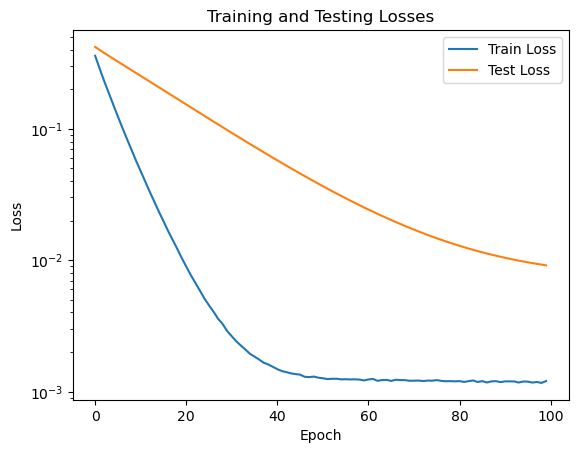

In [7]:
class Trainer:
    def __init__(self, model, optimizer, criterion, train_loader, val_loader):
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
        self.train_loader = train_loader
        self.val_loader = val_loader
    
    def train(self, max_epochs):
        self.train_losses = []
        self.val_losses = []

        # Training
        for epoch in range(max_epochs):
            self.model.train
            train_loss = 0

            for inputs, labels in self.train_loader:
                self.optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = self.criterion(outputs.squeeze(), labels)  # Assuming output shape is [batch_size, 1]
                loss.backward()
                self.optimizer.step()
                train_loss += loss.item() * inputs.size(0)
            train_loss /= len(self.train_loader.dataset)
            self.train_losses.append(train_loss)

            # Validation
            self.model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for inputs, labels in self.val_loader:
                    outputs = self.model(inputs)
                    loss = self.criterion(outputs.squeeze(), labels)
                    val_loss += loss.item() * inputs.size(0)
                val_loss /= len(self.val_loader.dataset)
            self.val_losses.append(val_loss)

            if epoch % 10 == 0:
                print(f'Epoch {epoch+1}/{max_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {val_loss:.4f}')
 
        return self.model
    
    def plot_losses(self, train_losses, test_losses):
        plt.plot(train_losses, label='Train Loss')
        plt.plot(test_losses, label='Test Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.yscale('log')  # Set y-axis scale to logarithmic
        plt.title('Training and Testing Losses')
        plt.legend()
        plt.show()
    
    def evaluation(self, model, test_loader):
        model.eval()
        with torch.no_grad():
            test_preds = []
            test_targets = []
            for inputs, labels in test_loader:
                outputs = model(inputs)
                test_preds.extend(outputs.squeeze().tolist())
                test_targets.extend(labels.tolist())
        test_r2 = r2_score(test_targets, test_preds)

        return test_r2
            

trainer = Trainer(model, optimizer, criterion, train_loader, val_loader)   
model = trainer.train(100)      
trainer.plot_losses(trainer.train_losses, trainer.val_losses)